# Expert Collapse Analysis

This notebook analyzes the results of experiments designed to study "expert collapse" in Mixture-of-Experts (MoE) models. The experiments were launched using the `4_experts_centralized.sh` script, which systematically varies the initialization variance of router and expert weights.

## Objectives

1.  **Data Collection**: Download metrics from WandB for runs related to expert collapse experiments.
2.  **Metric Analysis**: Analyze metrics logged by `RouterSimilarityCallback` and `ExpertSelectionCallback`.
3.  **Router Similarity**: Investigate how router weight initialization (`r_std_multiplier`) affects the cosine similarity between router weights. High similarity may indicate that routers are not learning diverse routing strategies.
4.  **Expert Selection**: Study how router and expert initialization (`r_std_multiplier`, `e_std_multiplier`) impact expert selection patterns, load balancing (KL divergence), and score distributions.
5.  **Visualization**: Create plots to visualize the relationships between initialization parameters and the observed metrics.

## Key Metrics

-   **`r_std_multiplier`**: Multiplier for the standard deviation of router weight initialization.
-   **`e_std_multiplier`**: Multiplier for the standard deviation of expert weight initialization.
-   **Router Cosine Similarity**:
    -   `expert_router/.../cosine_sim/off_diag_mean`: Mean of the off-diagonal elements of the router weight cosine similarity matrix. A high value suggests routers are similar.
-   **Expert Selection KL Divergence**:
    -   `expert_selection/.../top-1/kl_vs_uniform`: KL divergence of the top-1 expert selection distribution from a uniform distribution. A high value indicates imbalanced expert usage (potential collapse).
-   **Expert Scores**:
    -   `expert_selection/.../scores_histogram/.../mean`: Mean of the scores for each expert.
    -   `expert_selection/.../scores_histogram/.../std`: Standard deviation of the scores for each expert.


In [1]:
import logging

from fedmoe_plots.data_analysis import (
    aggregate_expert_collapse_data,
    fetch_expert_collapse_runs,
)
from fedmoe_plots.plotting_utils import (
    configure_logging_for_jupyter,
    plot_expert_collapse_heatmaps,
    plot_expert_collapse_metrics,
    plot_expert_score_statistics,
    run_matplotlib_preamble,
)

# Configure logging and plotting styles
configure_logging_for_jupyter()
log = logging.getLogger("expert_collapse_analysis.ipynb")

CUSTOM_FONTS = True
USE_INVERTED_STYLE = False
BACKEND = "inline"

color_palette, line_styles, patterns = run_matplotlib_preamble(
    custom_fonts=CUSTOM_FONTS,
    use_inverted_style=USE_INVERTED_STYLE,
    backend=BACKEND,
)

In [ ]:
# --- WandB and Data Fetching Configuration ---
WANDB_PROJECT = "camlsys/photon"
RUN_NAME_REGEX = "^n_n_exp_coll_sigma_r"

# --- Analysis Configuration ---
# Metrics to download from wandb.
# We are interested in the final values of these metrics.
METRICS_TO_FETCH = [
    # Router similarity metrics
    "expert_router/eval/block_0/cosine_sim/off_diag_mean",
    "expert_router/eval/block_1/cosine_sim/off_diag_mean",
    "expert_router/eval/block_2/cosine_sim/off_diag_mean",
    "expert_router/eval/block_3/cosine_sim/off_diag_mean",
    # Expert selection KL divergence (load balance)
    "expert_selection/eval/block_0/top-1/kl_vs_uniform",
    "expert_selection/eval/block_1/top-1/kl_vs_uniform",
    "expert_selection/eval/block_2/top-1/kl_vs_uniform",
    "expert_selection/eval/block_3/top-1/kl_vs_uniform",
]

# Add expert score metrics for all 4 experts and 4 blocks
for block_idx in range(4):
    for expert_idx in range(4):
        METRICS_TO_FETCH.extend(
            (
                f"expert_selection/eval/scores_histogram/block_"
                f"{block_idx}/expert_{expert_idx}/{stat}"
            )
            for stat in ["mean", "std", "min", "max"]
        )

log.info("Will fetch %d metrics from WandB", len(METRICS_TO_FETCH))

expert_collapse_analysis.ipynb - INFO - Will fetch 72 metrics from WandB


### Data Collection

Now, we will iterate through the fetched runs, extract the hyperparameters (`r_std_multiplier`, `e_std_multiplier`, and `seed`), and download the final values of the metrics we are interested in. The results will be stored in a list of dictionaries, which will then be converted to a Pandas DataFrame for easier analysis.

In [3]:
# Fetch expert collapse data using the utility function
results_df = fetch_expert_collapse_runs(
    wandb_project=WANDB_PROJECT,
    run_name_regex=RUN_NAME_REGEX,
    metrics_to_fetch=METRICS_TO_FETCH,
)

# Display the first few rows of the dataframe
if not results_df.empty:
    log.info("DataFrame shape: %s", results_df.shape)
    log.info("Columns: %s", results_df.columns.tolist())
    display(results_df.head())
else:
    log.warning("No data was processed.")

fedmoe_plots.data_analysis - INFO - Found 3 runs matching the filter '^n_n_exp_coll_sigma_r'.


Processing runs: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

fedmoe_plots.data_analysis - INFO - Successfully processed 3 runs.
expert_collapse_analysis.ipynb - INFO - DataFrame shape: (3, 77)
expert_collapse_analysis.ipynb - INFO - Columns: ['run_name', 'run_id', 'r_std_multiplier', 'e_std_multiplier', 'seed', 'expert_router/eval/block_0/cosine_sim/off_diag_mean', 'expert_router/eval/block_1/cosine_sim/off_diag_mean', 'expert_router/eval/block_2/cosine_sim/off_diag_mean', 'expert_router/eval/block_3/cosine_sim/off_diag_mean', 'expert_selection/eval/block_0/top-1/kl_vs_uniform', 'expert_selection/eval/block_1/top-1/kl_vs_uniform', 'expert_selection/eval/block_2/top-1/kl_vs_uniform', 'expert_selection/eval/block_3/top-1/kl_vs_uniform', 'expert_selection/eval/scores_histogram/block_0/expert_0/mean', 'expert_selection/eval/scores_histogram/block_0/expert_0/std', 'expert_selection/eval/scores_histogram/block_0/expert_0/min', 'expert_selection/eval/scores_histogram/block_0/expert_0/max', 'expert_selection/eval/scores_histogram/block_0/expert_1/mean',

,run_name,run_id,r_std_multiplier,e_std_multiplier,seed,expert_router/eval/block_0/cosine_sim/off_diag_mean,expert_router/eval/block_1/cosine_sim/off_diag_mean,expert_router/eval/block_2/cosine_sim/off_diag_mean,expert_router/eval/block_3/cosine_sim/off_diag_mean,expert_selection/eval/block_0/top-1/kl_vs_uniform,...,expert_selection/eval/scores_histogram/block_3/expert_1/min,expert_selection/eval/scores_histogram/block_3/expert_1/max,expert_selection/eval/scores_histogram/block_3/expert_2/mean,expert_selection/eval/scores_histogram/block_3/expert_2/std,expert_selection/eval/scores_histogram/block_3/expert_2/min,expert_selection/eval/scores_histogram/block_3/expert_2/max,expert_selection/eval/scores_histogram/block_3/expert_3/mean,expert_selection/eval/scores_histogram/block_3/expert_3/std,expert_selection/eval/scores_histogram/block_3/expert_3/min,expert_selection/eval/scores_histogram/block_3/expert_3/max
0,n_n_exp_coll_sigma_r0.1_e0.1_20250808_142255_c...,n_n_exp_coll_sigma_r0.1_e0.1_20250808_142255_c...,0.1,0.1,1337,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,n_n_exp_coll_sigma_r0.1_e0.5_20250808_142300_c...,n_n_exp_coll_sigma_r0.1_e0.5_20250808_142300_c...,0.1,0.5,1337,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,n_n_exp_coll_sigma_r0.1_e1.0_20250808_142305_c...,n_n_exp_coll_sigma_r0.1_e1.0_20250808_142305_c...,0.1,1.0,1337,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Data Aggregation and Preparation

Before plotting, we'll aggregate the data. For each combination of `r_std_multiplier` and `e_std_multiplier`, we will calculate the mean and standard deviation of the metrics across different seeds. This will help us understand the general trend and the variability of the results.

We will also average the metrics across all transformer blocks to get a single value per run for router similarity and KL divergence.

In [6]:
# Aggregate expert collapse data using the utility function
aggregated_metrics = aggregate_expert_collapse_data(results_df)

if not aggregated_metrics.empty:
    log.info("Aggregated DataFrame:")
    display(aggregated_metrics)
else:
    log.warning("Results DataFrame is empty. Skipping aggregation.")

expert_collapse_analysis.ipynb - INFO - Aggregated DataFrame:


,r_std_multiplier,e_std_multiplier,mean_off_diag,std_off_diag,mean_kl_div,std_kl_div,mean_score_mean,std_score_mean,mean_score_std,std_score_std,run_count
0,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### Analysis and Visualization

Now we will create plots to visualize the collected and aggregated data.

#### 1. Router Cosine Similarity vs. Initialization Multipliers

This plot shows how the average off-diagonal cosine similarity of the router weights changes with different `r_std_multiplier` and `e_std_multiplier` values. Higher values indicate that routers are more similar to each other, which could be a precursor to expert collapse.

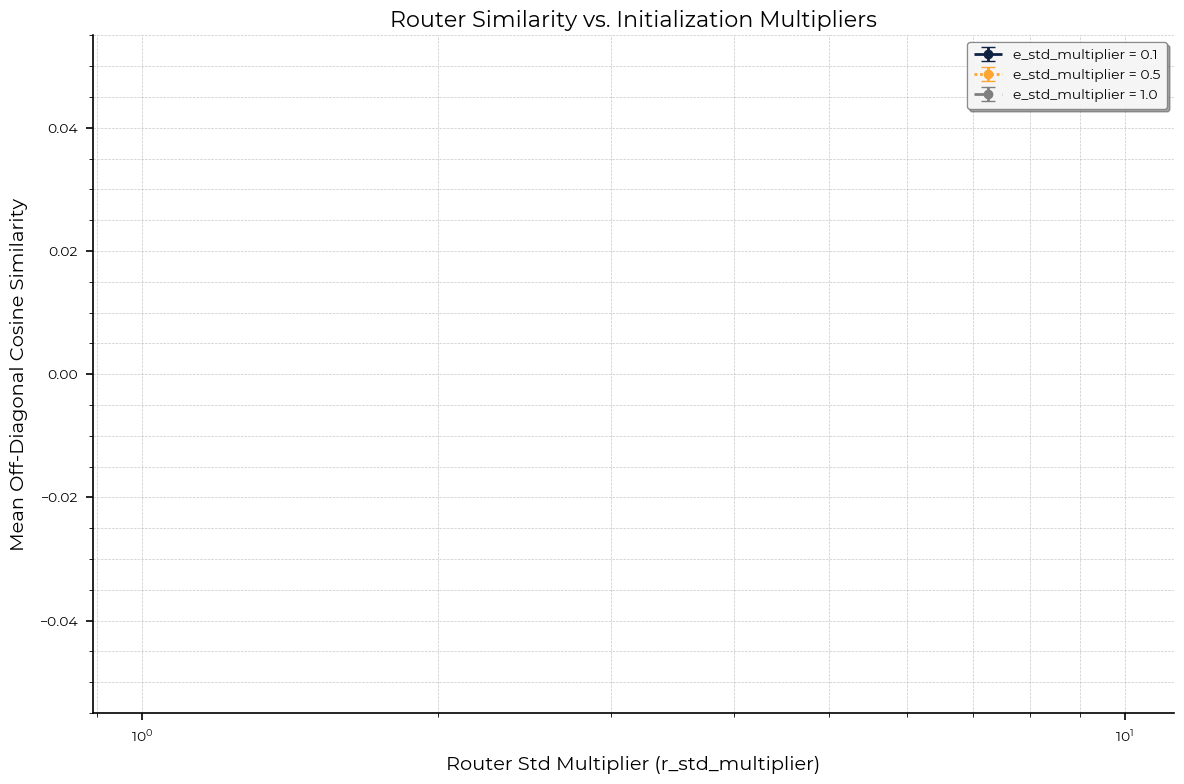

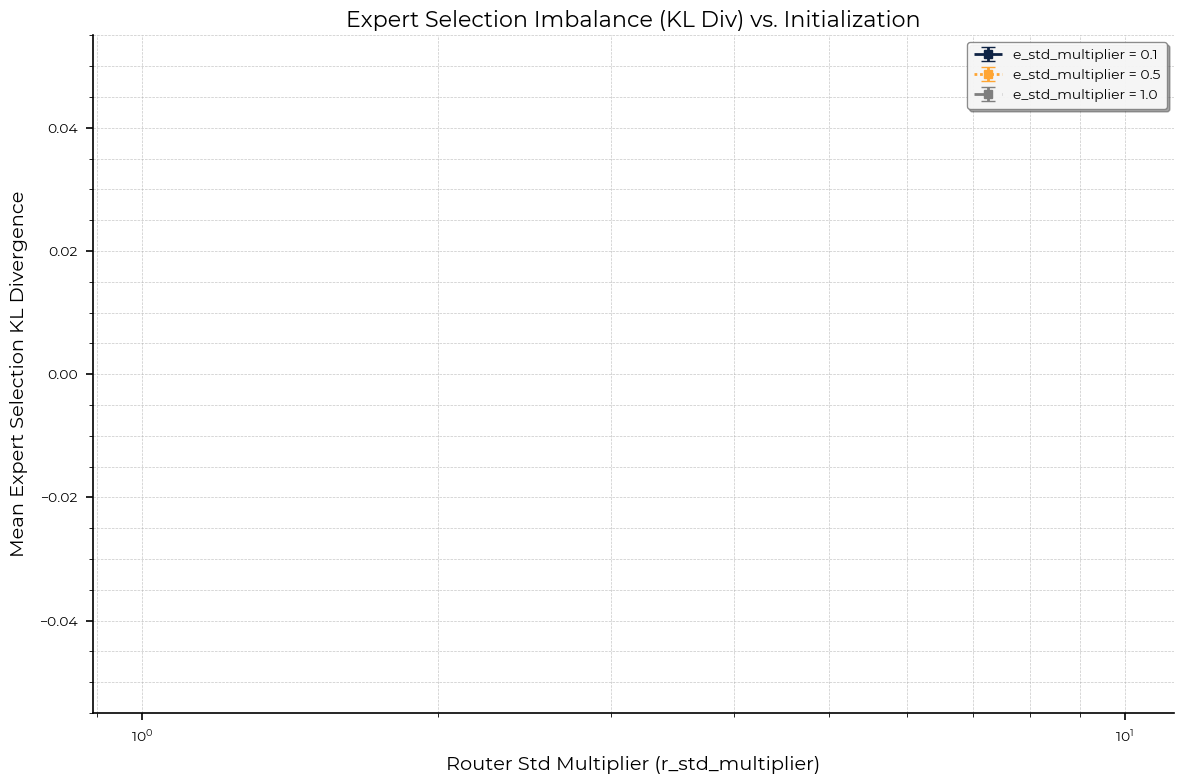

In [ ]:
# Plot router similarity and KL divergence using utility functions
plot_expert_collapse_metrics(
    agg_df=aggregated_metrics, color_palette=color_palette, line_styles=line_styles,
)

#### 2. Heatmaps of Router Similarity and KL Divergence

The following heatmaps provide a 2D view of how the combination of `r_std_multiplier` and `e_std_multiplier` affects router similarity and expert selection imbalance.

/nfs-share/ls985/projects/fedmoe_plots/fedmoe_plots/plotting_utils.py:628: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im1 = ax1.imshow(pivot_sim, cmap="viridis", interpolation="nearest")
/nfs-share/ls985/projects/fedmoe_plots/fedmoe_plots/plotting_utils.py:628: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im1 = ax1.imshow(pivot_sim, cmap="viridis", interpolation="nearest")
/nfs-share/ls985/projects/fedmoe_plots/fedmoe_plots/plotting_utils.py:652: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im2 = ax2.imshow(pivot_kl, cmap="plasma", interpolation="nearest")
/nfs-share/ls985/projects/fedmoe_plots/fedmoe_plots/plotting_utils.py:652: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im2 = ax2.imshow(pivot_

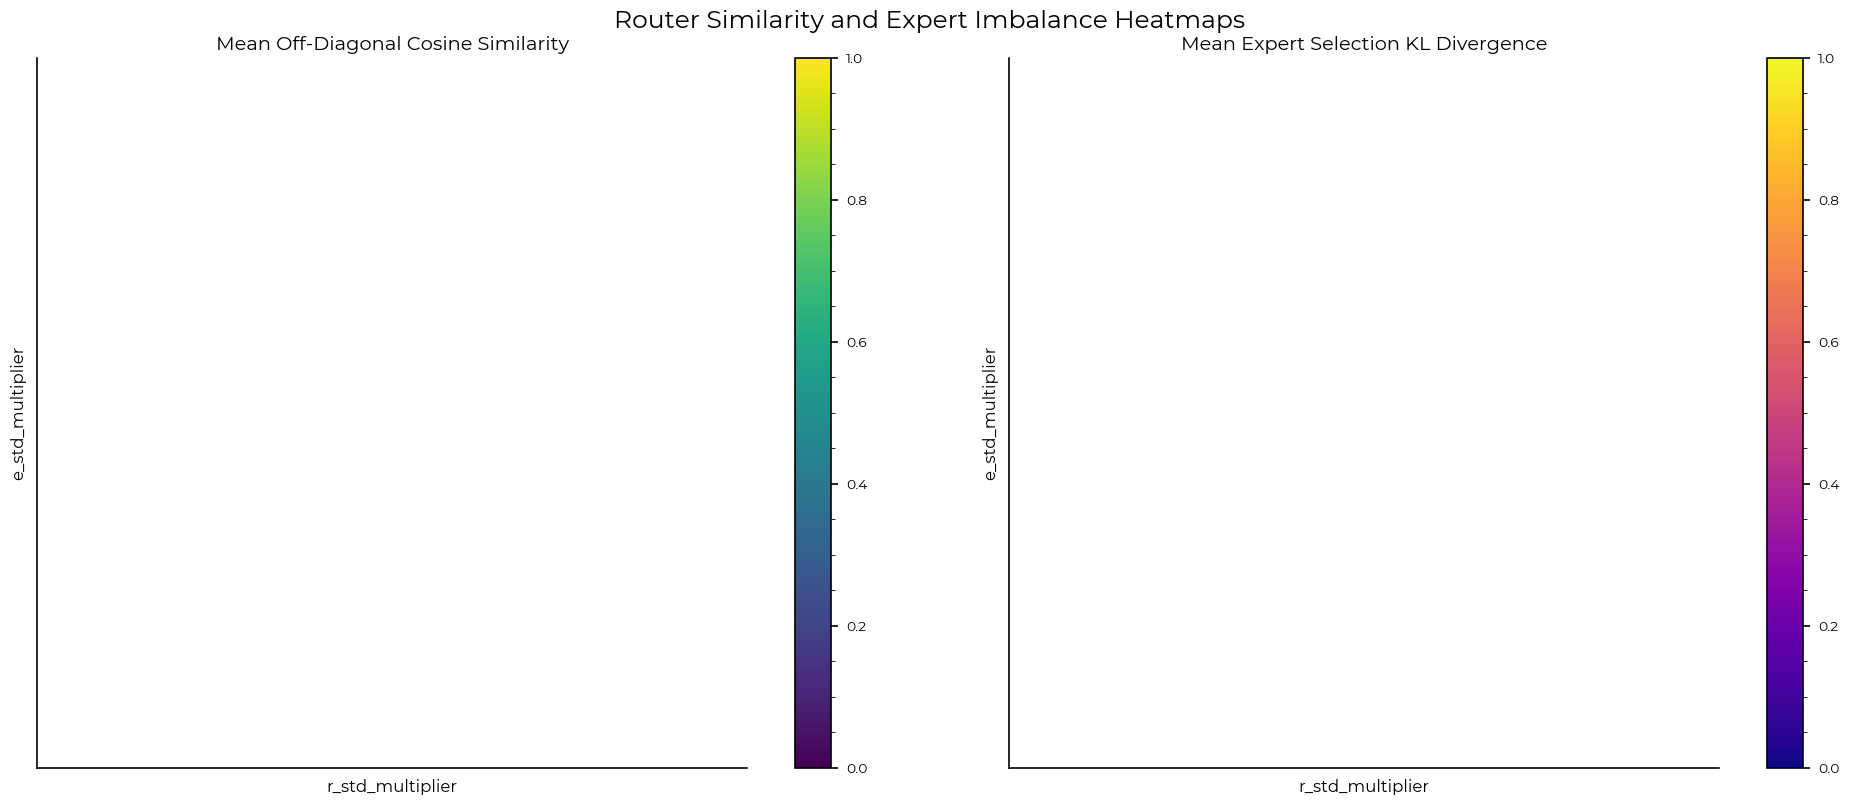

In [12]:
# Create heatmaps for router similarity and KL divergence metrics
if not aggregated_metrics.empty:
    plot_expert_collapse_heatmaps(agg_df=aggregated_metrics)
else:
    log.warning("No aggregated data available for heatmap plotting.")

#### 3. Expert Score Statistics

The following plots show the distribution of expert scores across different initialization settings, providing insights into how expert scoring varies.

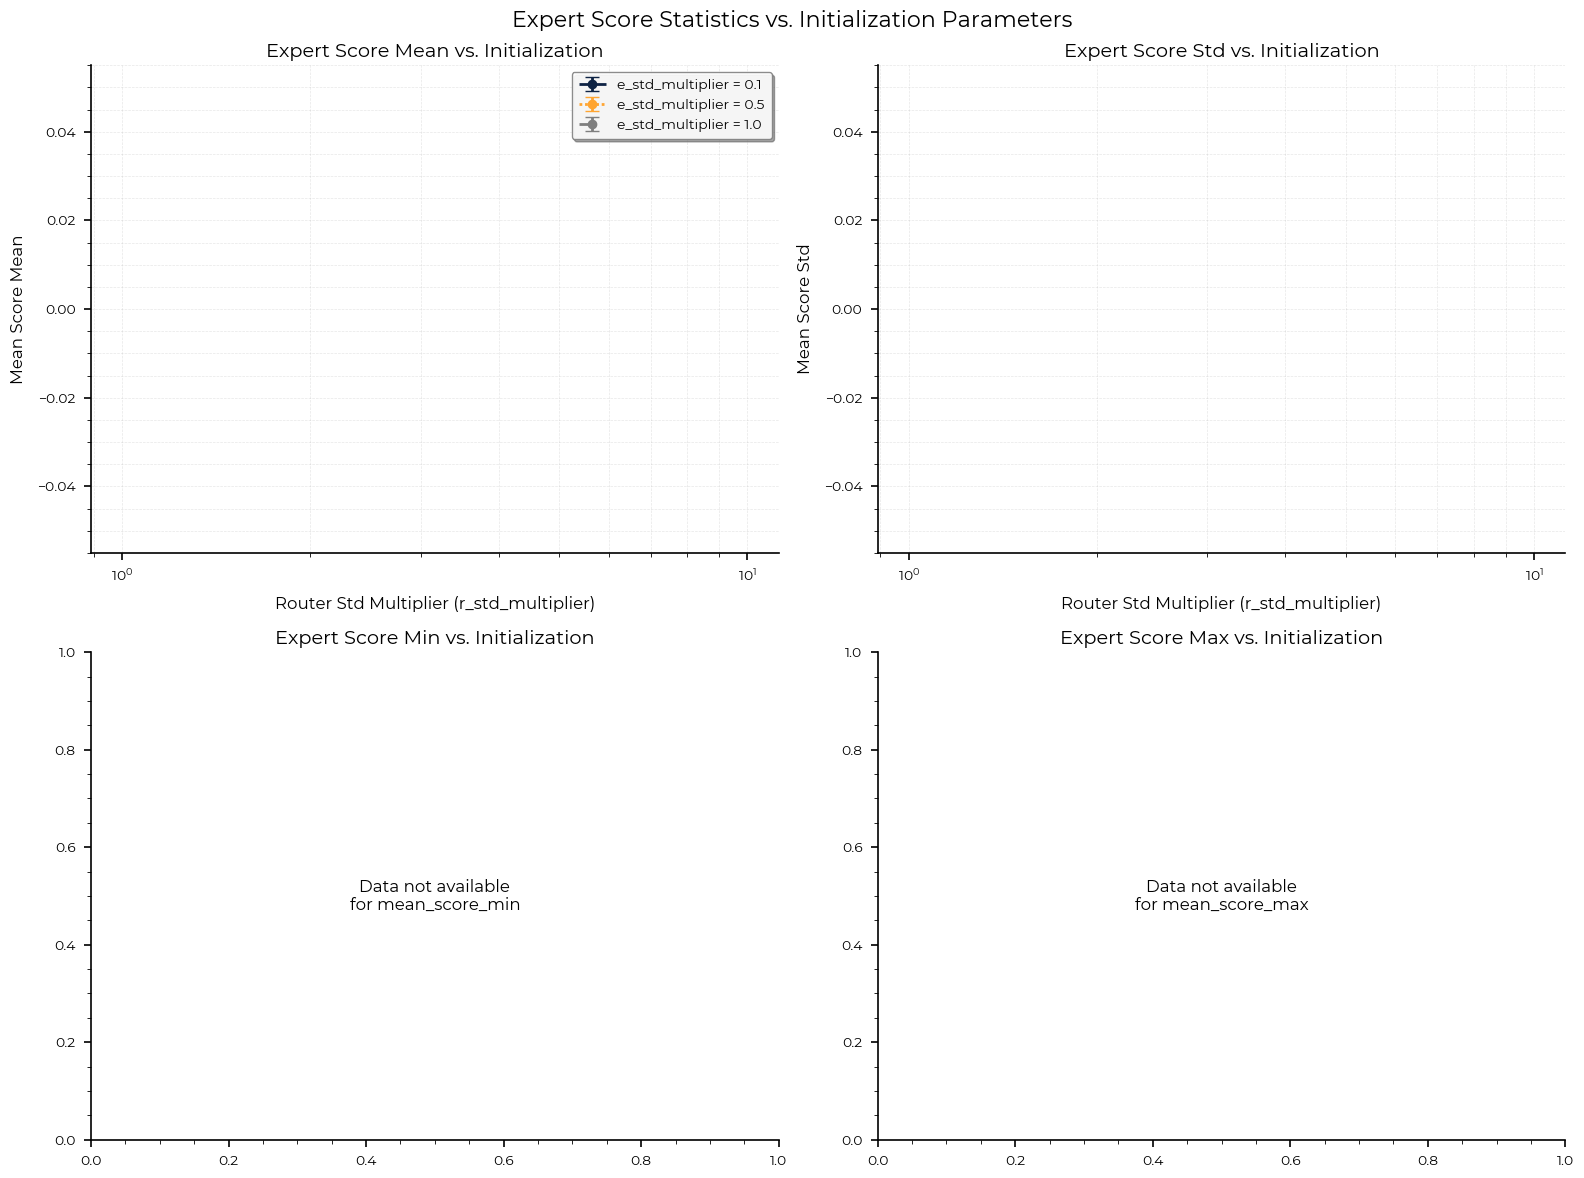

In [ ]:
# Plot expert score statistics using the aggregated data
if not aggregated_metrics.empty:
    plot_expert_score_statistics(
        agg_df=aggregated_metrics, color_palette=color_palette, line_styles=line_styles,
    )
else:
    log.warning("No aggregated data available for expert score statistics plotting.")

### Conclusion

From the plots above, we can draw conclusions about how router and expert initialization variances affect expert collapse.

- **Router Similarity**: As `r_std_multiplier` decreases, the router cosine similarity increases, especially for lower `e_std_multiplier` values. This suggests that lower initialization variance for routers makes them less distinct from each other.
- **Expert Selection Imbalance**: The KL divergence is highest for low `r_std_multiplier` values. This indicates that when routers are initialized to be very similar, the model quickly learns to favor a small subset of experts, leading to collapse. The `e_std_multiplier` has a less pronounced, but still noticeable, effect.

In summary, a very small initialization variance for the routers (`r_std_multiplier` << 1.0) is a strong driver of expert collapse in these experiments.